# Predictors of Medical Cost

For this project, we will be using this [medical cost personal data set](https://www.kaggle.com/datasets/mirichoi0218/insurance?resource=download) from Kaggle to inspect how different demographic and personal characteristics relate to total medical costs for individuals in the United States. The data set consists of individual medical insurance bills from individuals, with information about their age, sex, bmi, number of children, smoking status, and region of the US in which they live.



In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from scipy.stats import boxcox
from scipy.special import inv_boxcox

import matplotlib.pyplot as plt
import matplotlib.style as style
%matplotlib inline
import seaborn as sns

### Import and inspect data

In [2]:
mc = pd.read_csv("../Datasets/insurance.csv")

In [3]:
print(print(mc.shape))
print(mc.info())

(1338, 7)
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB
None


In [4]:
numerical_vars = ['age', 'bmi', 'children']
categorical_vars = ['sex', 'smoker', 'region']

In [5]:
mc.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [6]:
print(f"Missing Data: \n{mc.isnull().sum()}")

Missing Data: 
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64


In [7]:
print(mc.describe())

               age          bmi     children       charges
count  1338.000000  1338.000000  1338.000000   1338.000000
mean     39.207025    30.663397     1.094918  13270.422265
std      14.049960     6.098187     1.205493  12110.011237
min      18.000000    15.960000     0.000000   1121.873900
25%      27.000000    26.296250     0.000000   4740.287150
50%      39.000000    30.400000     1.000000   9382.033000
75%      51.000000    34.693750     2.000000  16639.912515
max      64.000000    53.130000     5.000000  63770.428010


In [8]:
for var in categorical_vars:
    print(mc[var].value_counts(), '\n')

male      676
female    662
Name: sex, dtype: int64 

no     1064
yes     274
Name: smoker, dtype: int64 

southeast    364
southwest    325
northwest    325
northeast    324
Name: region, dtype: int64 



All numerical variables have reasonable ranges, with no obvious data problems. The mean age is around 40 years old, with an average of one child per person and average medical charges of roughly \$13,000. Average BMI is fairly high at 30, and the middle 50\% of the data are also all overweight. Categorical variables are fairly well-balanced, with the exception of smoker status. The data set includes predominately non-smokers. This fact and the largely overweight status of the sample will be important factors to consider in our later interpretations.

## Inspect relationships of predictors to outcome variable

children    0.067998
bmi         0.198341
age         0.299008
charges     1.000000
Name: charges, dtype: float64


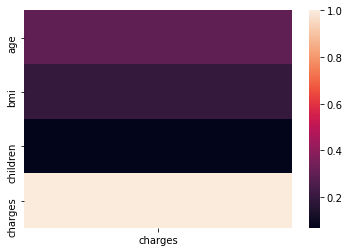

In [9]:
mc_corr = mc.corr()
sns.heatmap(mc_corr[['charges']])
print(mc_corr['charges'].sort_values())

In [10]:
print(mc_corr)

               age       bmi  children   charges
age       1.000000  0.109272  0.042469  0.299008
bmi       0.109272  1.000000  0.012759  0.198341
children  0.042469  0.012759  1.000000  0.067998
charges   0.299008  0.198341  0.067998  1.000000


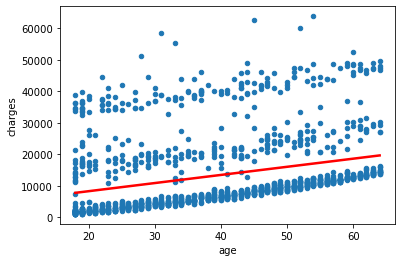

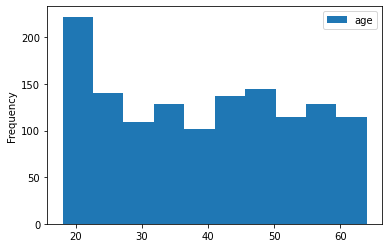

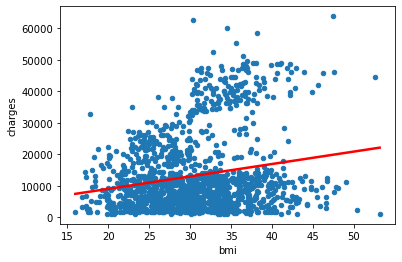

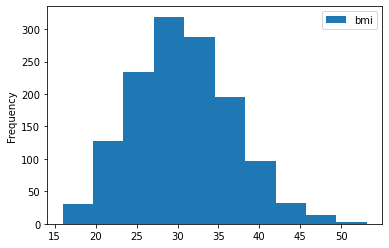

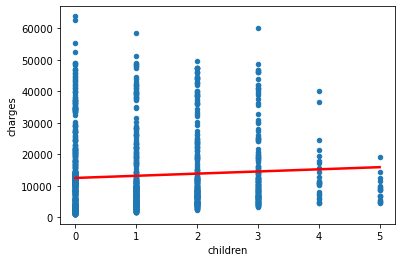

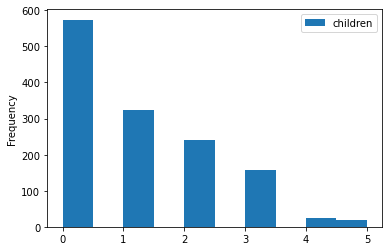

In [11]:
for var in numerical_vars:
    mc.plot.scatter(y='charges', x=var)
    # Fit linear regression via least squares with numpy.polyfit
    # It returns an slope (b) and intercept (a)
    b, a = np.polyfit(mc[var], mc['charges'], deg=1)
    # create number sequence along which to plot
    xseq = np.linspace(mc[var].min(), mc[var].max(), num=100)
    # Plot regression line
    plt.plot(xseq, a + b * xseq, color="red", lw=2.5);
    plt.show()
    
    # plot histogram
    mc[[var]].plot.hist()
    plt.show()

sex
female    12569.578844
male      13956.751178
Name: charges, dtype: float64 



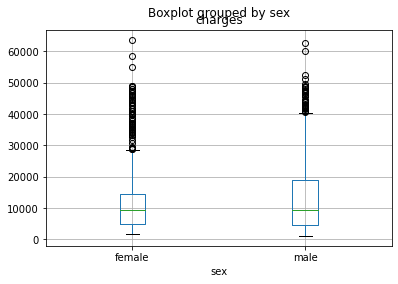

smoker
no      8434.268298
yes    32050.231832
Name: charges, dtype: float64 



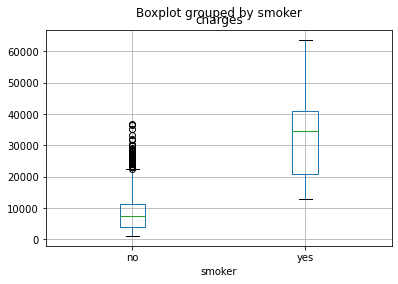

region
northeast    13406.384516
northwest    12417.575374
southeast    14735.411438
southwest    12346.937377
Name: charges, dtype: float64 



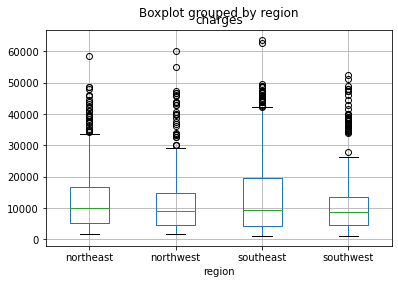

In [12]:
for var in categorical_vars:
    print(mc.groupby(var)['charges'].agg('mean', 'std'), '\n')
    mc.boxplot(column='charges', by=var)
    plt.show()

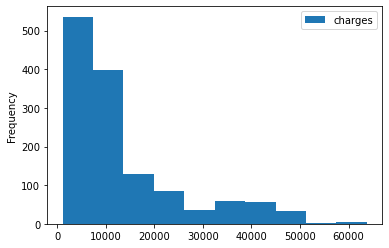

In [13]:
mc[['charges']].plot.hist()
plt.show()

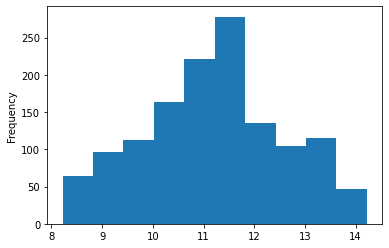

Boxcox lambda: 0.043649053770664956


In [14]:
mc['charges_boxcox'] = boxcox(mc['charges'])[0]
mc['charges_boxcox'].plot.hist()
plt.show()
boxcox_lambda_charges = boxcox(mc['charges'])[1]
print(f"Boxcox lambda: {boxcox_lambda_charges}")

Of numerical variables, age has a moderate correlation (~.3) and BMI a small correlation with the total medical charges. Inspecting the scatterplots, the age relationship with charges seems legitimate, although at any given age, there appear to be three categories of charges one could receive. The correlation of charges with BMI appears to be spurious, based on the increase in variance of charges with increasing BMI. Past 30 BMI, there appear to be two categories of charges that one might have. Relationships between categorical varibles and charges are less clear for sex and region and seem to be predominately affected by outliers. However, there appears to be a strong relationship between smoker status and charges, with smokers having much higher charges. 

Thus, the most important variables for inclusion in our model, in order of apparent importance, are: `smoker`, `age`, `bmi`. If we were to include other variables, their order of importance appears to be: `region`, `sex`, `children`. We will begin by checking how each variable improves R^2 and RMSE. Then, we will check R^2 improvement on a validation set for variables whose individual R^2 contribution is > .01. Finally, we'll create a combined model with those variables whose individual R^2 contribution is > .01 in the validation set and check its performance on the test set.

One final notable feature of the data set is that our outcome variable is highly positively skewed, meaning that we have far less data regarding higher charges. Performing a boxcox transformation normalizes the variable well, so it may be worth inspecting the final model with this variable as well.

## Create data subsets for modeling

In [15]:
mc_dum = pd.get_dummies(data=mc, columns=categorical_vars, drop_first=True)

In [16]:
X = mc_dum.copy().drop(columns='charges')
y = mc_dum['charges']

In [17]:
_scaler = StandardScaler()
_scaler.fit(X)
X_scaled = _scaler.transform(X)

In [18]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=444)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2*X.shape[0]/X_train.shape[0], random_state=444) # note test_size is modified so that it's 20% of X, not of X_train

## Modeling

### Individual factor models

We'll compare the R^2 of each factor to a model with the intercept only.

In [19]:
one_factor_l = {'vars': ['intercept only', 'smoker', 'age', 'bmi', 'region', 'sex', 'children'], 
               'train_mse': [],
               'train_rmse': [],
               'train_R2': []}
loop_keys = ['train_mse', 'train_rmse', 'train_R2']

#### Intercept only model

In [20]:
X_ones = pd.DataFrame({'int': [1]*len(y_train)})

int_only_m = LinearRegression()
int_only_m.fit(X_ones, y_train)
print(f"Intercept only model intercept: {int_only_m.intercept_}\nCoefficients: {int_only_m.coef_}") # weird that intercept doesn't match mean in 'describe': 13270.42
train_predictions = int_only_m.predict(X_ones)
train_mse = mean_squared_error(y_train, train_predictions)
train_rmse = mean_squared_error(y_train, train_predictions, squared=False)
train_R2 = r2_score(y_train, train_predictions)
vals = [train_mse, train_rmse, train_R2]

for key, val in zip(loop_keys, vals):
    one_factor_l[key].append(val)

Intercept only model intercept: 12811.644668927682
Coefficients: [0.]


#### Other models

In [21]:
for col in one_factor_l['vars'][1:]:
    curr_cols = X_train.columns[X_train.columns.str.contains(col)].values.tolist()
    X_train_subset = X_train[curr_cols]
    
    m = LinearRegression()
    m.fit(X_train_subset, y_train)
    train_predictions = m.predict(X_train_subset)
    train_mse = mean_squared_error(y_train, train_predictions)
    train_rmse = mean_squared_error(y_train, train_predictions, squared=False)
    train_R2 = r2_score(y_train, train_predictions)
    vals = [train_mse, train_rmse, train_R2]

    for key, val in zip(loop_keys, vals):
        one_factor_l[key].append(val)

In [22]:
one_factor_df = pd.DataFrame(one_factor_l)
one_factor_df.sort_values('train_R2')

,vars,train_mse,train_rmse,train_R2
0,intercept only,1.407364e+08,11863.236009,0.000000
5,sex,1.395385e+08,11812.643520,0.008511
4,region,1.394239e+08,11807.791227,0.009325
6,children,1.391919e+08,11797.963000,0.010974
3,bmi,1.330845e+08,11536.225432,0.054370
2,age,1.276970e+08,11300.311394,0.092651
1,smoker,5.506235e+07,7420.400660,0.608755


These models show that `smoker` is an extremely good predictor, `age` and `bmi` reasonable predictors, `children` a passable predictor, and the others not particularly useful predictors. The R^2 seen here is the R^2 we can expect our validation and test data models to have.

### Models using validation data set

In [23]:
one_factor_val_l = {'vars': ['smoker', 'age', 'bmi', 'region', 'sex', 'children'], 
               'val_mse': [],
               'val_rmse': [],
               'val_R2': []}
loop_keys = ['val_mse', 'val_rmse', 'val_R2']

In [24]:
for col in one_factor_val_l['vars']:
    curr_cols = X_val.columns[X_val.columns.str.contains(col)].values.tolist()
    X_train_subset = X_train[curr_cols]
    X_val_subset = X_val[curr_cols]
    
    m = LinearRegression()
    m.fit(X_train_subset, y_train)
    val_predictions = m.predict(X_val_subset)
    val_mse = mean_squared_error(y_val, val_predictions)
    val_rmse = mean_squared_error(y_val, val_predictions, squared=False)
    val_R2 = r2_score(y_val, val_predictions)
    vals = [val_mse, val_rmse, val_R2]

    for key, val in zip(loop_keys, vals):
        one_factor_val_l[key].append(val)

In [25]:
one_factor_val_df = pd.DataFrame(one_factor_val_l)
one_factor_val_df.sort_values('val_R2')

,vars,val_mse,val_rmse,val_R2
4,sex,1.918457e+08,13850.836934,-0.035442
3,region,1.907292e+08,13810.473069,-0.029416
5,children,1.906304e+08,13806.896318,-0.028883
2,bmi,1.839899e+08,13564.288170,0.006957
1,age,1.751885e+08,13235.879599,0.054461
0,smoker,5.726348e+07,7567.264001,0.690934


The `children` and `bmi` variables no longer makes the cut, but `smoker` and `age` do. Let's see how our model with these two variables fits the test data.

### Final Test Model

In [26]:
curr_cols = X_val.columns[X_val.columns.str.contains('smoker|age')].values.tolist()
X_train_subset = X_train[curr_cols]
X_test_subset = X_test[curr_cols]

m = LinearRegression()
m.fit(X_train_subset, y_train)

train_predictions = m.predict(X_train_subset)
train_mse = mean_squared_error(y_train, train_predictions)
train_rmse = mean_squared_error(y_train, train_predictions, squared=False)
train_R2 = r2_score(y_train, train_predictions)

test_predictions = m.predict(X_test_subset)
test_mse = mean_squared_error(y_test, test_predictions)
test_rmse = mean_squared_error(y_test, test_predictions, squared=False)
test_R2 = r2_score(y_test, test_predictions)

m_coef = m.coef_

In [27]:
X_train_subset.head()

,age,smoker_yes
146,46,1
795,27,1
305,29,0
775,51,0
442,18,0


In [28]:
print(
f"MSE Train: {train_mse}\n\
MSE Test: {test_mse}\n\n\
RMSE Train: {train_rmse}\n\
RMSE Test: {test_rmse}\n\n\
R^2 Train: {train_R2}\n\
R^2 Test: {test_R2}\n\n\
Coefficients-- age: {m_coef[0]}, smoker: {m_coef[1]}"
)

MSE Train: 40906081.413352676
MSE Test: 41907535.44558323

RMSE Train: 6395.786223237349
RMSE Test: 6473.60297250173

R^2 Train: 0.7093424974707316
R^2 Test: 0.6490734793805675

Coefficients-- age: 270.0836388242424, smoker: 23596.706895859963


### Examine model residuals

In [29]:
residuals = y_test-test_predictions
print(f"Training model residual mean: {np.mean(y_train-train_predictions)}\n\
Test model residual mean: {np.mean(residuals)}")

Training model residual mean: 9.588251500611107e-13
Test model residual mean: -338.4215859802473


Although our training model's residual mean is near zero, the mean of residuals in our test data is negative. This indicates a bias toward underestimating costs in our model's predictions for the test data.

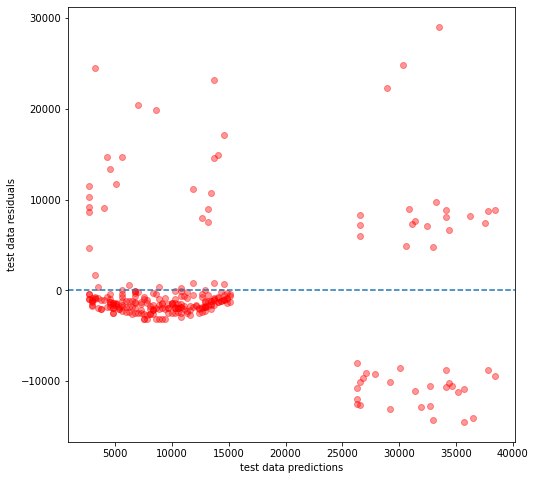

In [30]:
plt.figure(figsize=[8,8])
plt.scatter(test_predictions, residuals, color = 'red', alpha=0.4)
plt.xlabel('test data predictions')
plt.ylabel('test data residuals')
plt.axhline(0, ls='--')
plt.show()

In [31]:
print(f"Residual mean (pred < $20K): {np.mean(residuals[test_predictions<20000])}\n\
Residual mean (pred > $20K): {np.mean(residuals[test_predictions>20000])}")

Residual mean (pred < $20K): 3.7154011571045436
Residual mean (pred > $20K): -1947.1933765622612


A plot of the predicted vs. residual values in the test data shows that predictions were generally good for lower charge values but worse for higher charge values. This result is consistent with the distribution of the charges, as there were far fewer high charges in the dataset than low charges. Looking closer at the residuals, the residual mean is actually very close to zero for predictions less than \\$20,000, but is negatively biased for predictions greater than \$20,000.

### Final Test Model with boxcox charges

In [32]:
X = mc_dum.copy().drop(columns=['charges', 'charges_boxcox'])
y = mc_dum['charges_boxcox']

In [33]:
_scaler = StandardScaler()
_scaler.fit(X)
X_scaled = _scaler.transform(X)

In [34]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=444)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2*X.shape[0]/X_train.shape[0], random_state=444) # note test_size is modified so that it's 20% of X, not of X_train

In [35]:
curr_cols = X_val.columns[X_val.columns.str.contains('smoker|age')].values.tolist()
X_train_subset = X_train[curr_cols]
X_test_subset = X_test[curr_cols]

m = LinearRegression()
m.fit(X_train_subset, y_train)

train_predictions = m.predict(X_train_subset)
train_mse = mean_squared_error(y_train, train_predictions)
train_rmse = mean_squared_error(y_train, train_predictions, squared=False)
train_R2 = r2_score(y_train, train_predictions)

test_predictions = m.predict(X_test_subset)
test_mse = mean_squared_error(y_test, test_predictions)
test_rmse = mean_squared_error(y_test, test_predictions, squared=False)
test_R2 = r2_score(y_test, test_predictions)

m_coef = m.coef_

In [36]:
print(
f"MSE Train: {train_mse}\n\
MSE Test: {test_mse}\n\n\
RMSE Train: {train_rmse}\n\
RMSE Test: {test_rmse}\n\n\
R^2 Train: {train_R2}\n\
R^2 Test: {test_R2}\n\n\
Coefficients-- age: {m_coef[0]}, smoker: {m_coef[1]}"
)

MSE Train: 0.49294996661343315
MSE Test: 0.4540192478184655

RMSE Train: 0.7021039571270291
RMSE Test: 0.6738095041022095

R^2 Train: 0.7371617451428532
R^2 Test: 0.6923433561427499

Coefficients-- age: 0.05341852591913936, smoker: 2.3362744938732884


### Examine model residuals

In [37]:
residuals = y_test-test_predictions
print(f"Training model residual mean: {np.mean(y_train-train_predictions)}\n\
Test model residual mean: {np.mean(residuals)}")

Training model residual mean: 1.800720835950628e-15
Test model residual mean: 0.021806550427503752


This model is far less biased than the model with an untransformed charges variable.

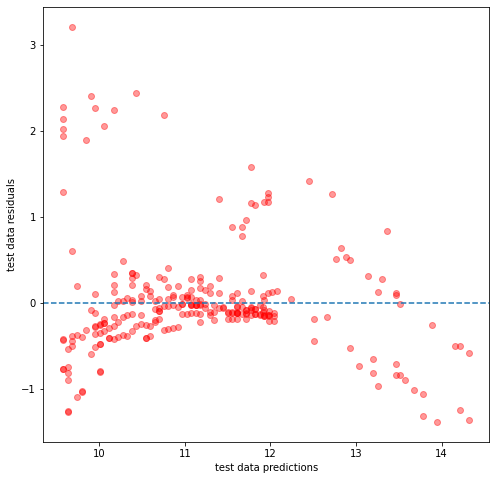

In [38]:
plt.figure(figsize=[8,8])
plt.scatter(test_predictions, residuals, color = 'red', alpha=0.4)
plt.xlabel('test data predictions')
plt.ylabel('test data residuals')
plt.axhline(0, ls='--')
plt.show()

A plot of the predicted vs. residual values in the test data shows that predictions were much better on average for boxcox transformed charges than untransformed charges. However, The residuals show a clear negative quadratic trend, introducing a further element to correct in our model. If we were to revise the model further and interpret the boxcox coefficients, we would want to address this quadratic trend. Additionally, we could not simply invert the transformation on the coefficients, as they are linear only for the boxcox variable. We would want to use the model to predict a value for a given age and smoker status, and then invert the value with the inverse boxcox transformation. Alternatively, we could preemptively create a predicted line from the minimum to the maximum of our age range for smokers and non-smokers and inverse boxcox transform these predictions to graph out our expectations for future cases based on the model.

## Conclusions

By inspecting the R^2 contribution of six variables, we were able to find two variables--smoker status and age--that created a reasonably good predictive model of medical costs in the United States, explaining 65% of the variance in medical costs in the test data. The model provides two main takeaways. First, controlling for age, being a smoker costs one roughly \\$23,600 more in medical bills than does being a non-smoker. Additionally, for each year in age, controlling for smoker status, one can expect to spend roughly \$270 more on medical bills.

Given that higher medical bills imply more medical care requirements, the interpretation of these results is simple: **hospitals in regions including older populations and, especially, populations with more smokers should be allocated more resources to care for patients.**

Several caveats are important to keep in mind in these interpretations. First, the data set had far fewer smokers than non-smokers--only about 300 smokers compared to 1000 non-smokers. Because of this, the prediction for medical cost differences is less precise than it might be with more data from smokers. Second, The data set includes predominately overweight individuals. Therefore, the predictions from this model may not generalize to individuals with a healthier BMI. Third, most of the data included charges less than \\$20,000, which caused predictions greater than \\$20,000 to be negatively skewed. Thus, predictions from this model should be taken with an abundance of caution when the predicted cost is over \$20,000.

Redoing the best fit model with a normalized distribution of the charges variable improved the model. Variance explained rose by roughly 5\%, residual mean decreased to near zero, and the spread of residuals improved. However, it also introduced further problems of interpretation and prediction--the coefficients are not as readily interpretable, and the residual plot showed that further revision of the model would be necessary. Based on the improvement of only 5\% in variance explained, we have decided not to further revise the model and instead suggest implementation of the model with untransformed charges.